In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import json
from tqdm.auto import tqdm
import os
import numpy as np

In [127]:
from sesm import get_data
from trainer import PLModel

In [128]:
def get_freer_gpu():
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmax(memory_available)


free_gpu_id = get_freer_gpu()
print(free_gpu_id)
torch.cuda.set_device(torch.device(free_gpu_id))

2


In [129]:
config = json.load(open("configs/ecg.json", "r"))

In [130]:
train_loader, test_loader, _, max_len = get_data(
    config["dataset"], config["batch_size"]
)

In [131]:
plmodel = PLModel.load_from_checkpoint(
    checkpoint_path="lightning_logs/sesm_ecg/version_286/checkpoints/last.ckpt",
    hparams_file="lightning_logs/sesm_ecg/version_286/hparams.yaml",
)

In [132]:
# from torchinfo import summary

In [133]:
# for batch in train_loader:
#     x, y = batch
#     break
# summary(plmodel.model, (x.shape))

In [134]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    auc,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

In [135]:
model = plmodel.model.cuda()
model.eval()
model.training

False

## AOPC

In [11]:
AOPC = torch.zeros(8)
total = 0

for x,y in tqdm(test_loader):
    x,y = x.cuda(), y.cuda() 
    y_hat_, _, attn1, attn2 = model(x, x != 0, heads=True) 
    batch_size = x.shape[0]
    
    attn2 = attn2.detach().cpu()
    y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
    
    attn_arg = torch.sort(attn2, 1, descending=True)[1] 
    
    attn_logits = y_hat_ * attn2.unsqueeze(-1)
    
    logits_sorted_attn = torch.gather(attn_logits, 1, attn_arg.unsqueeze(2).repeat(1, 1, 5))
    
    batch_aopc = torch.zeros((batch_size, config['n_heads']))
    
    
    for i in range(config['n_heads']):
        # batch_aopc[:, i] = F.softmax(attn_logits[:, i:].sum(1), -1)[torch.arange(batch_size), y.cpu()]
    
        AOPC[i] += F.softmax(attn_logits[:, i:].sum(1), -1)[torch.arange(batch_size), y.cpu()].sum()
        
    total += batch_size
    # break

print(AOPC / total)
    
         

  0%|          | 0/55 [00:00<?, ?it/s]

tensor([0.9847, 0.9821, 0.9119, 0.8843, 0.8026, 0.6171, 0.5846, 0.5033])


/storage/zyf/mambaforge/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


tensor(0.7838)

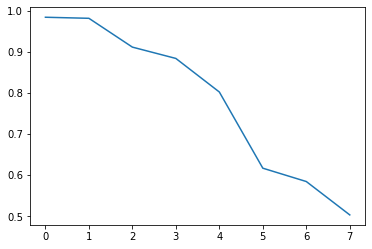

In [12]:
sns.lineplot(np.arange(8), (AOPC / total).numpy())
(AOPC / total).mean()

In [40]:
attn_logits = (y_hat_ * attn2.unsqueeze(-1))
attn_logits.shape

torch.Size([400, 8, 5])

In [46]:
attn_arg = torch.sort(attn2.detach(), 1, descending=True)[1] 
attn_arg.shape

torch.Size([400, 8])

In [43]:
logits_sorted_attn = torch.gather(attn_logits, 1, attn_arg.unsqueeze(2).repeat(1, 1, 5))
logits_sorted_attn.shape

torch.Size([400, 8, 5])

In [49]:
F.softmax(attn_logits[:, i:].sum(1), -1)[torch.arange(config['batch_size']), y.cpu()]

tensor([0.5154, 0.9541, 0.2596, 0.1958, 0.5922, 0.4052, 0.7570, 0.7359, 0.4457,
        0.4637, 0.6014, 0.5824, 0.7753, 0.6195, 0.4564, 0.3610, 0.2783, 0.3971,
        0.5137, 0.5275, 0.5188, 0.3448, 0.3002, 0.1920, 0.7234, 0.3507, 0.5948,
        0.1809, 0.2167, 0.4179, 0.8205, 0.1951, 0.2014, 0.3883, 0.1995, 0.5747,
        0.4463, 0.9984, 0.3526, 0.7704, 0.1365, 0.3334, 0.5709, 0.5893, 0.3608,
        0.5946, 0.6105, 0.8473, 0.4923, 0.4068, 0.6742, 0.7270, 0.6589, 0.1994,
        0.9037, 0.4070, 0.7013, 0.7121, 0.6922, 0.3998, 0.5874, 0.7319, 0.5994,
        0.7255, 0.3601, 0.4331, 0.5513, 0.3422, 0.3772, 0.6082, 0.4379, 0.3026,
        0.7597, 0.7866, 0.2413, 0.4078, 0.5729, 0.2568, 0.3004, 0.3255, 0.4787,
        0.8793, 0.4236, 0.4416, 0.5533, 0.4767, 0.4300, 0.7310, 0.8600, 0.4967,
        0.4011, 0.7467, 0.3980, 0.8315, 0.5110, 0.2888, 0.6788, 0.3947, 0.6496,
        0.4515, 0.5340, 0.2448, 0.4135, 0.4361, 0.2426, 0.8497, 0.4930, 0.7012,
        0.6595, 0.8086, 0.6455, 0.8535, 

## accuracy

In [136]:
x_orig = []
y_pred = []
y_true = []
attention1 = []
attention2 = []
predicted_head = []

# model = model.cuda()

for x, y in tqdm(test_loader):
    x, y = x.cuda(), y.cuda()
    batch_size = x.shape[0]
    y_hat_, _, attn1, attn2 = model(x, x != 0, heads=True) 
    
    y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
    attn1 = attn1.detach().cpu()
    attn2 = attn2.detach().cpu() 
    x = x.detach().cpu()
    y = y.detach().cpu()
    
    y_hat = (y_hat_ * attn2.unsqueeze(-1)).sum(1)
    
    x_orig.append(x.numpy())
    y_pred.append(y_hat.argmax(1).numpy())
    y_true.append(y.numpy())
    attention1.append(attn1.numpy())
    attention2.append(attn2.numpy())
    predicted_head.append(F.softmax(y_hat_, -1).numpy())
    del x, y, y_hat_, y_hat, _, attn1, attn2
    

x_orig = np.concatenate(x_orig)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
attention1 = np.concatenate(attention1)
attention2 = np.concatenate(attention2)
predicted_head = np.concatenate(predicted_head)

  0%|          | 0/219 [00:00<?, ?it/s]

In [13]:
(
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred, average="macro"),
    recall_score(y_true, y_pred, average="macro"),
)

(0.9871174052078575, 0.9254750239940979, 0.9330925355760472)

In [14]:
predicted_head[0, 0]

array([0.3811375 , 0.44171932, 0.00335293, 0.01085569, 0.16293459],
      dtype=float32)

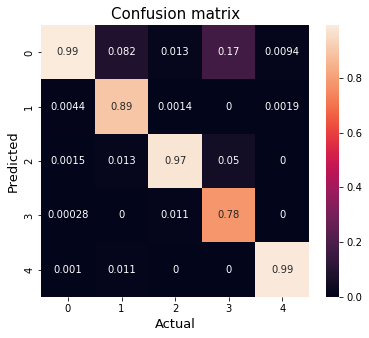

In [15]:
C = confusion_matrix(y_true, y_pred)
C = C / C.astype(float).sum(axis=0)

fig, ax = plt.subplots(figsize=(6, 5))
# cm_ = ax.imshow(C, cmap="hot")
sns.heatmap(C, annot=True)
ax.set_title("Confusion matrix", fontsize=15)
ax.set_xlabel("Actual", fontsize=13)
ax.set_ylabel("Predicted", fontsize=13)
# plt.colorbar(cm_)
plt.show()

In [16]:
max_len = 187

In [141]:
attention1.shape, attention2.shape

((87556, 8, 178), (87556, 8))

In [137]:
selection = np.zeros((attention1.shape[0], attention1.shape[1], max_len))
for i in tqdm(range(attention1.shape[0])):
    for h in range(attention1.shape[1]):
        for k in range(attention1.shape[-1]):
            if attention1[i, h, k] > 0:
                left = max(0, k - 5)
                right = min(max_len, k + 5)
                selection[i, h, left:right] = 1

selection.shape

  0%|          | 0/87556 [00:00<?, ?it/s]

(87556, 8, 187)

In [138]:
" ".join([str(i) for i in (np.where(y_true == 4) and np.where(y_pred == 4))[0]][:100])

'0 4 5 14 19 34 43 65 66 95 104 108 115 122 132 141 142 145 154 164 187 198 220 227 236 280 292 316 356 361 364 397 420 426 465 476 486 509 525 541 553 554 616 649 654 675 681 686 689 717 745 747 749 806 811 823 869 870 873 899 922 928 930 935 939 987 991 1028 1031 1033 1035 1038 1057 1075 1103 1107 1117 1121 1128 1147 1181 1200 1213 1215 1218 1225 1237 1244 1247 1291 1325 1330 1350 1353 1365 1371 1375 1384 1389 1394'

0 0
[0.31469041109085083, 1.2100586891174316, 0.12827956676483154, 0.36278679966926575, 0.6162081360816956, 0.22845935821533203, 0.24589036405086517, 0.6566517353057861]
1 1
[0.5253962874412537, 0.07307351380586624, 3.2380456924438477, 1.3814640045166016, 0.002690220484510064, 0.003358004614710808, 0.023716045543551445, 0.05535921826958656]
2 2
[0.07766472548246384, 0.12514720857143402, 0.022490128874778748, 0.023003792390227318, 0.7220900654792786, 1.4966994524002075, 0.03714027628302574, 0.06405777484178543]
3 3
[0.04162049666047096, 0.7419418692588806, 0.006869141012430191, 0.006109108682721853, 2.6835403442382812, 0.03485981002449989, 0.0071727135218679905, 0.30297616124153137]
4 4
[0.5246480107307434, 0.640977680683136, 0.10823563486337662, 0.6100265383720398, 0.010995358228683472, 0.001074570813216269, 0.023329248651862144, 0.15677879750728607]


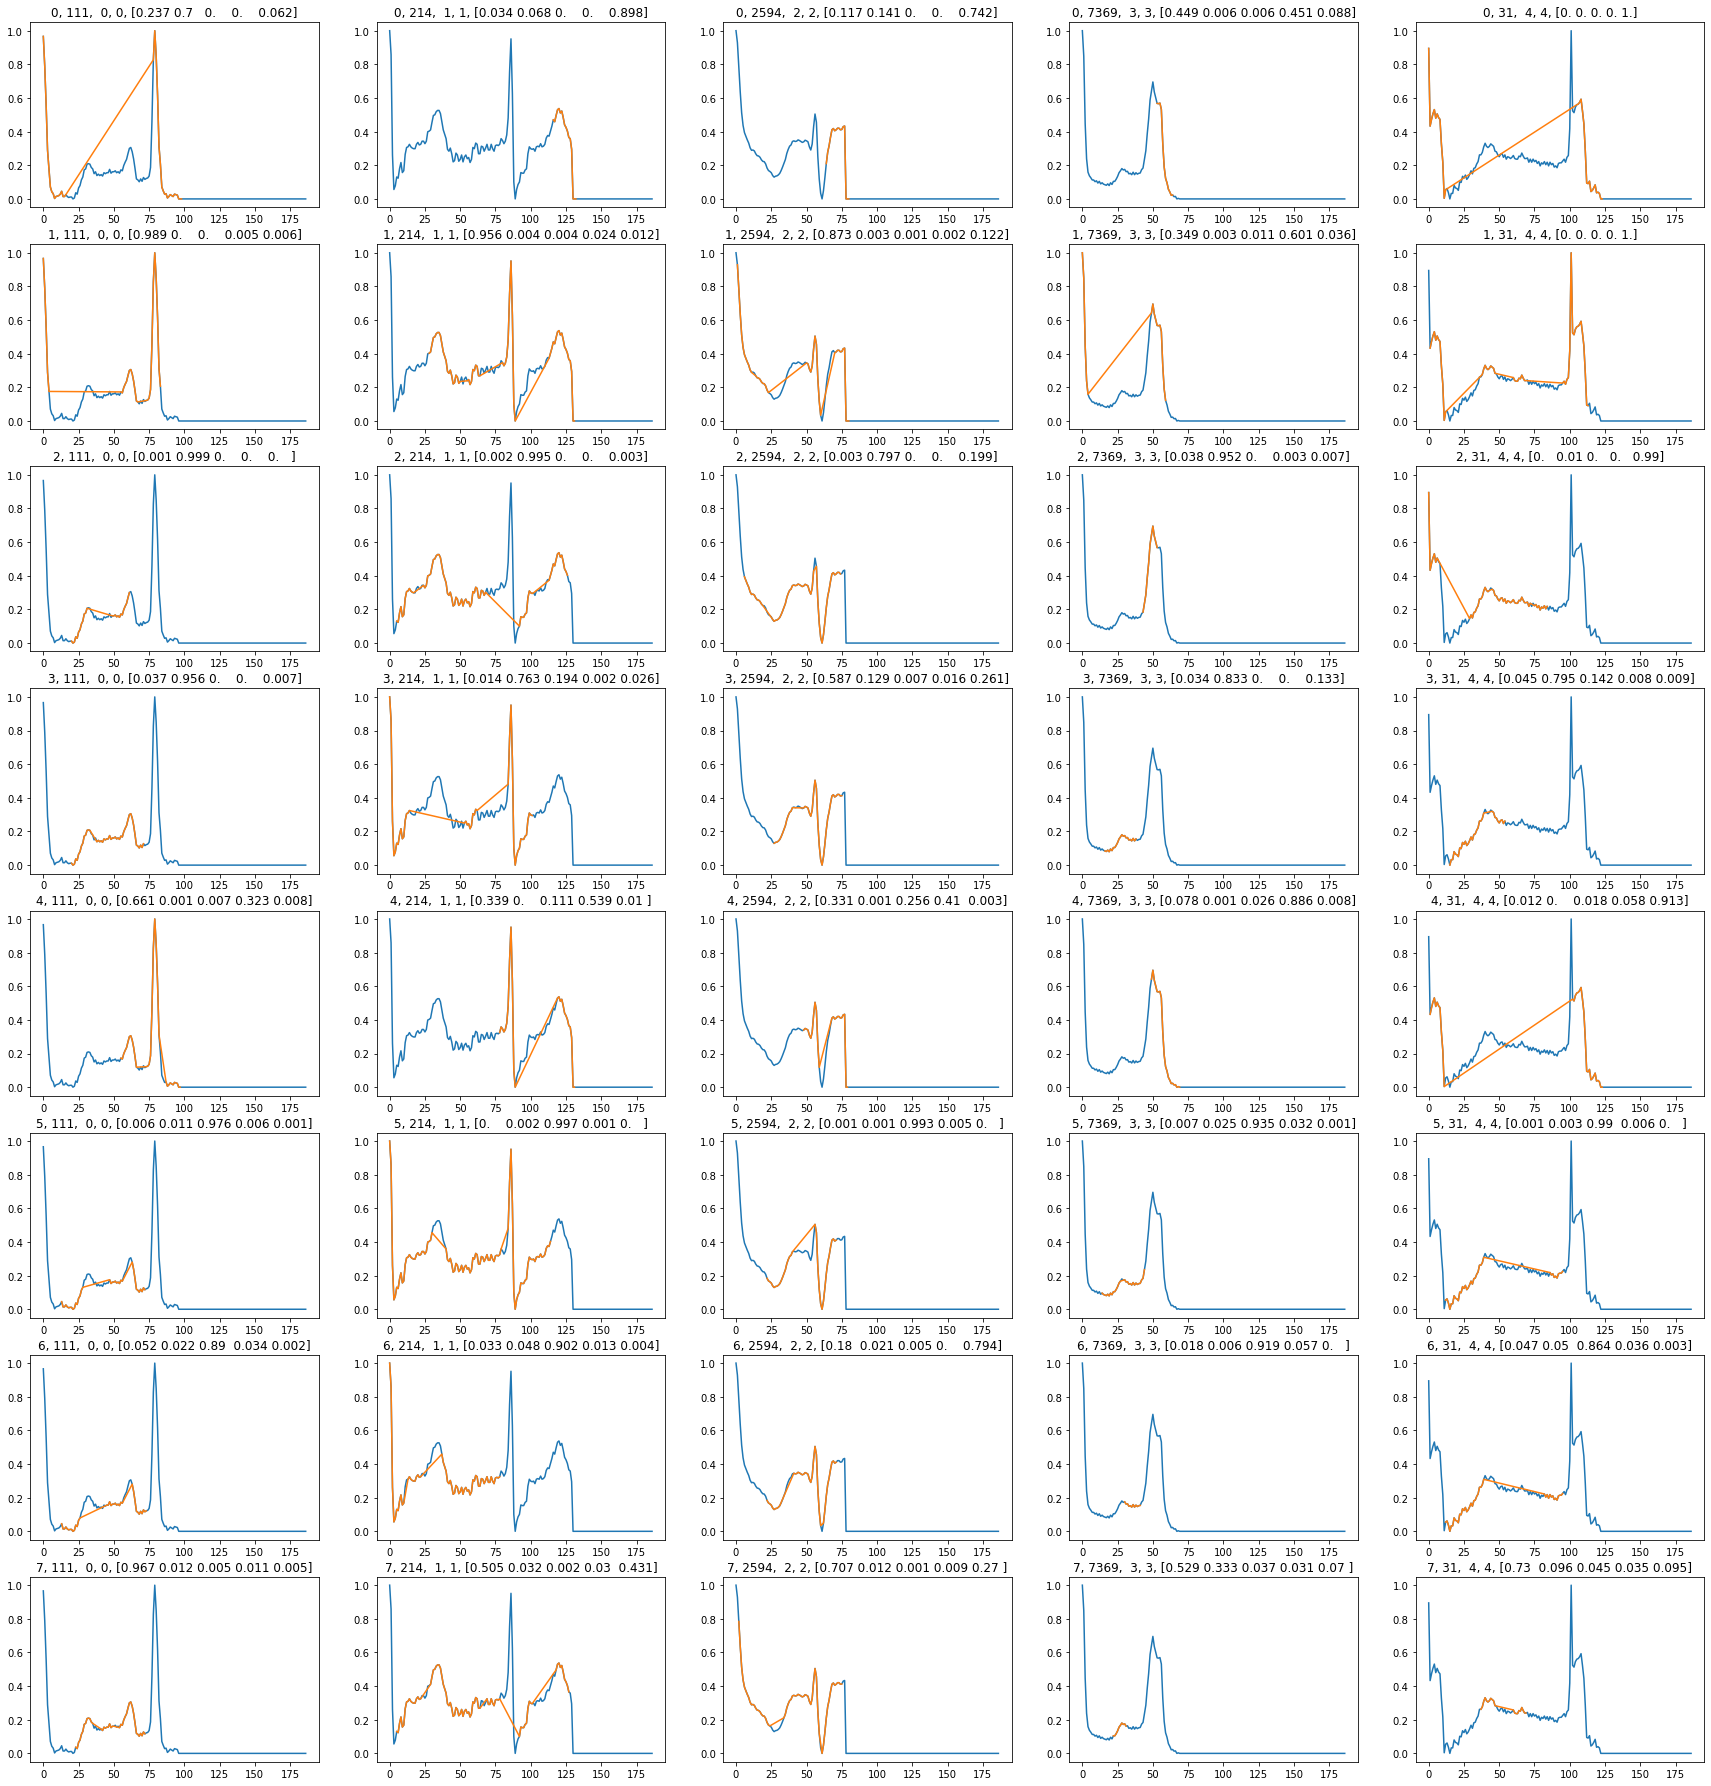

In [112]:
# indices = np.array([[24, 25], [28, 214], [27, 13883], [14552, 6043], [17, 31]]).flatten("F")
indices = np.array([111, 214, 2594, 7369, 31])
# indices = (np.where(y_true == 2) and np.where(y_pred == 2))[0][1:6]

n = len(indices)
fig, ax = plt.subplots(8, 5, figsize=(30, 32))
# ax = axes.flatten()


for i in range(n):
    idx = indices[i]
    print(y_true[idx], y_pred[idx])
    print(attention2[idx].tolist())

    for head in range(8):

        # print(selection[idx].sum(-1))
        # head = selection[idx].sum(-1).argmax()


        sns.lineplot(x=np.arange(max_len), y=x_orig[idx], ax=ax[head, i])

        # print((x_orig[idx] * selection[idx, head]).sum())

        nonzero = np.nonzero(selection[idx, head])[0]

        sns.lineplot(x=nonzero, y=x_orig[idx, nonzero], ax=ax[head, i])

        # ax[head, i].title.set_text(
        #     f"{h}, {idx}, {attention2[idx, head]}, {y_true[idx]}, {y_pred[idx]}"
        # )
        ax[head, i].title.set_text(
            f"{head}, {idx},  {y_true[idx]}, {y_pred[idx]}, {np.around(predicted_head[idx, head], 3)}"
        )

In [19]:
idx = 557   
for d in range(x_orig.shape[1]):
    print(x_orig[idx,d ], end=',')

0.78114086,0.70547146,0.61816067,0.55995345,0.48079163,0.41094297,0.330617,0.2491269,0.16181606,0.119906865,0.08498254,0.05005821,0.017462166,0.0,0.026775321,0.09895227,0.15017462,0.17229337,0.19208382,0.20023283,0.2153667,0.25844005,0.2840512,0.32712457,0.36554134,0.40395808,0.41327125,0.42956927,0.44004658,0.45634457,0.4691502,0.49243307,0.50523865,0.5331781,0.5518044,0.5820722,0.60302675,0.6332945,0.6507567,0.66821885,0.6763679,0.6845169,0.6798603,0.67287546,0.653085,0.6332945,0.6018626,0.5750873,0.53667057,0.5064028,0.47380674,0.45168802,0.42840514,0.4225844,0.40512222,0.40279394,0.39580908,0.39697322,0.39348078,0.39348078,0.38649592,0.39464495,0.38882422,0.39697322,0.3911525,0.3993015,0.4016298,0.40861467,0.40745053,0.4144354,0.41559952,0.42142025,0.41792783,0.42374855,0.42142025,0.42607683,0.42142025,0.4330617,0.42724097,0.43422586,0.43422586,0.44004658,0.44935971,0.46798602,0.48894063,0.50523865,0.5168801,0.52852154,0.5064028,0.5133877,0.5168801,0.5133877,0.4935972,0.49010476,0.

In [117]:
head = 5
selection[idx, head], attention2[idx, head], predicted_head[idx, head]
for d in range(selection.shape[2]):
    if selection[idx, head, d] == 1:
        print(x_orig[idx, d], end=',')
    else:
        print(' ', end=',')

 , , , , , , , , , , , , , ,0.09602649,0.08774834,0.08443709,0.081125826,0.08940397,0.0794702,0.09602649,0.08609272,0.104304634,0.104304634,0.117549665,0.13410597,0.15562914,0.16721854, , ,0.17549668,0.16225165,0.16390729,0.14900662,0.15231788,0.14403974,0.1589404,0.14403974,0.15562914,0.147351,0.15231788,0.1539735,0.17384106,0.18377483,0.23509933, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

In [119]:
for h in range(8):
    print(h, round(attention2[idx, h], 3), [round(d, 3) for d in predicted_head[idx, h].tolist()])

0 0.315 [0.237, 0.7, 0.0, 0.0, 0.062]
1 1.21 [0.989, 0.0, 0.0, 0.005, 0.006]
2 0.128 [0.001, 0.999, 0.0, 0.0, 0.0]
3 0.363 [0.037, 0.956, 0.0, 0.0, 0.007]
4 0.616 [0.661, 0.001, 0.007, 0.323, 0.008]
5 0.228 [0.006, 0.011, 0.976, 0.006, 0.001]
6 0.246 [0.052, 0.022, 0.89, 0.034, 0.002]
7 0.657 [0.967, 0.012, 0.005, 0.011, 0.005]


In [62]:
attention2[idx, [1, 7]].sum()

2.4162297

/storage/zyf/mambaforge/envs/torch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

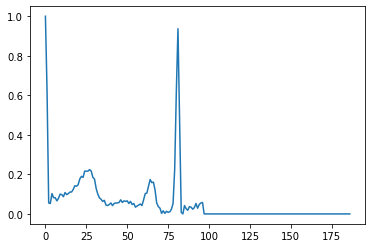

In [27]:
sns.lineplot(np.arange(187), x_orig[0])

In [143]:
rep_head = np.argpartition(attention2, -3)[:, -3:] 
rep_head

array([[3, 2, 0],
       [7, 1, 4],
       [5, 1, 4],
       ...,
       [7, 4, 1],
       [3, 4, 1],
       [7, 4, 1]])

In [144]:
counts = np.zeros(8)
results = [[], [], [], [], [], [], [], []]
for i in tqdm(range(selection.shape[0])):
    # print('x')
    # for d in range(x_orig.shape[1]):
    #     print(x_orig[i,d], end=',')
    # print('')
    for j in range(3):
        if counts[rep_head[i, j]] >= 10:
            continue
        counts[rep_head[i, j]] += 1
        results[rep_head[i, j]].append((x_orig[i], selection[i, rep_head[i, j]]))
        # print('head', rep_head[i, j])
        # for d in range(selection.shape[2]):
        #     if selection[i, rep_head[i, j], d] == 1:
        #         print(x_orig[i, d], end=',')
        #     else:
        #         print(' ', end=',')
        # print('')

  0%|          | 0/87556 [00:00<?, ?it/s]

In [145]:
import pandas as pd

In [146]:
for h in range(8):
    with open(f'prototypes{h}.csv', 'w') as f:
        for i in range(len(results[0])):
            x_, s_ = results[h][i]
            p_ = []
            for d in range(len(x_)):
                if s_[d] == 1: 
                    p_.append(str(x_[d])) 
                else:
                    p_.append(' ') 
            f.writelines(','.join([str(d) for d in x_])) 
            f.writelines('\n')
            f.writelines(','.join(p_))  
            f.writelines('\n')
    
    df = pd.read_csv(f'prototypes{h}.csv', header=None)
    df.T.to_csv(f'prototypes{h}.csv', header=None)

In [58]:
predicted_head.max(2)

array([[0.44171932, 0.97918576, 0.97820777, ..., 0.8871438 , 0.74757826,
        0.7964625 ],
       [0.6480041 , 0.6828102 , 0.42944425, ..., 0.90574497, 0.73958945,
        0.74420387],
       [0.35830253, 0.99428916, 0.88296515, ..., 0.8820149 , 0.35433185,
        0.9387712 ],
       ...,
       [0.7131906 , 0.98391867, 0.9322042 , ..., 0.806905  , 0.62982357,
        0.72464895],
       [0.58531547, 0.892024  , 0.9999565 , ..., 0.8007606 , 0.999998  ,
        0.5198272 ],
       [0.6066462 , 0.93645215, 0.99453026, ..., 0.60907704, 0.6022016 ,
        0.9468797 ]], dtype=float32)

In [67]:
np.bincount(predicted_head.argmax(2)[:, h])#.sum(0)

array([18714,  1539,   414,   114,  1109])

In [82]:
a = []
for h in range(8):
    a.append(np.bincount(predicted_head.argmax(2)[:, h]))
a = np.vstack(a)
np.around(a / 21890, 3)

array([[0.372, 0.146, 0.   , 0.043, 0.439],
       [0.896, 0.001, 0.002, 0.019, 0.082],
       [0.119, 0.814, 0.006, 0.   , 0.061],
       [0.172, 0.659, 0.073, 0.   , 0.095],
       [0.407, 0.001, 0.087, 0.454, 0.051],
       [0.024, 0.126, 0.849, 0.001, 0.001],
       [0.264, 0.028, 0.629, 0.019, 0.061],
       [0.855, 0.07 , 0.019, 0.005, 0.051]])

In [30]:
np.argsort(predicted_head[:, 0, :], 1)

array([[2, 3, 4, 0, 1],
       [4, 2, 3, 1, 0],
       [4, 1, 3, 2, 0],
       ...,
       [2, 3, 1, 0, 4],
       [2, 1, 4, 3, 0],
       [2, 1, 3, 4, 0]])

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

n_classes = 5
b_y_true = label_binarize(y_true, classes=np.arange(n_classes))
b_y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

In [29]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(b_y_true[:, i], b_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(b_y_true.ravel(), b_y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/tmp/ipykernel_3564784/3958833219.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


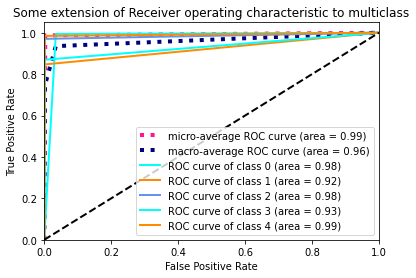

In [30]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [12]:
torch.gather(torch.tensor(y_true), 0, torch.tensor([86532,   68886, 37615, 45996, 41031]))

tensor([0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])